# **Final Project - Between Artificial and Human Intelligence**
shaked mishory 208017111


---



# Anchoring Bias

**Anchoring bias is a cognitive bias that occurs when individuals rely too heavily on the first piece of information they are exposed to** (the "anchor") when making decisions or estimating probabilities. This bias can lead to systematic errors, as the initial anchor may be unrelated to the decision at hand.

Anchoring bias can happen in a variety of contexts, such as negotiations, pricing, and decision-making. For example, **in a negotiation, the initial offer can act as an anchor, influencing subsequent offers and the final agreement.** In pricing, consumers may perceive a product as a good deal if its price is lower than an initial reference point, even if the reference point is arbitrary or irrelevant.

This bias occurs due to the brain's reliance on heuristics, or mental shortcuts, to make decisions quickly. **When faced with uncertainty, the brain tends to use the anchor as a starting point and adjusts insufficiently away from it, leading to biased outcomes.**

*Furnham, A., & Boo, H. C. (2011). A literature review of the anchoring effect. The journal of socio-economics, 40(1), 35-42.*


# Setup Environment

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

In [ ]:
from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import csv
import random
import bitsandbytes as bnb
from accelerate import Accelerator
import re
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_rel


In [ ]:
drive.mount('/content/drive')

# Testing For Anchoring Bias - Creating Benchmark

The benchmark consists of 100 prompts designed to test anchoring bias in the models. **Each prompt is related to a product category such as TVs, smartphones, or laptops, and includes a basic prompt asking for a reasonable price for that product.**

Additionally, **there is an anchored prompt for each product that provides a specific sale price as a reference.** The prompts are created by randomly selecting a product and an anchored price from predefined lists. I used a specific seed in the random number generator to ensure the reproducibility of the prompts generation process, allowing for consistent results across different runs.

**The goal is to evaluate the model's tendency to be influenced by the provided anchor (the sale price) when estimating the reasonable price.** By comparing the responses to the basic and anchored prompts, the benchmark aims to highlight any biases in the models' price estimation process, specifically related to anchoring bias.





In [ ]:
def create_benchmark(seed=42):
  """
  Creates a benchmark to test anchoring bias in deep learning models.

  Args:
  - seed (int): The seed for the random number generator for reproducibility.
  """
  random.seed(seed)

  products = ["TV", "smartphone", "watch", "laptop", "headphones", "camera", "tablet", "speaker", "microwave", "vacuum cleaner"]
  prices = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

  basic_template = "A reasonable price for a {} is (Answer with only one numeric value): "
  anchored_template = "A store offers a {} at a sale price of {} dollars. A reasonable price for a {} is (Answer with only one numeric value): "

  # Create a list to hold all prompts
  all_prompts = []
  generated_prompts = set()

  # Generate 100 prompts
  while len(all_prompts) < 100:
      product = random.choice(products)
      anchored_price = random.choice(prices)

      basic_prompt = basic_template.format(product)
      anchored_prompt = anchored_template.format(product, anchored_price, product)

      # Check if the prompt is unique
      prompt_key = (product, anchored_price, basic_prompt, anchored_prompt)
      if prompt_key not in generated_prompts:
          all_prompts.append(list(prompt_key))
          generated_prompts.add(prompt_key)

  # Write prompts to CSV
  with open('anchoring_bias_prompts.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['product', 'anchored_price', 'basic_prompt', 'anchored_prompt'])
      writer.writerows(all_prompts)

In [ ]:
create_benchmark(seed=42)

**first rows of the benchmark:**
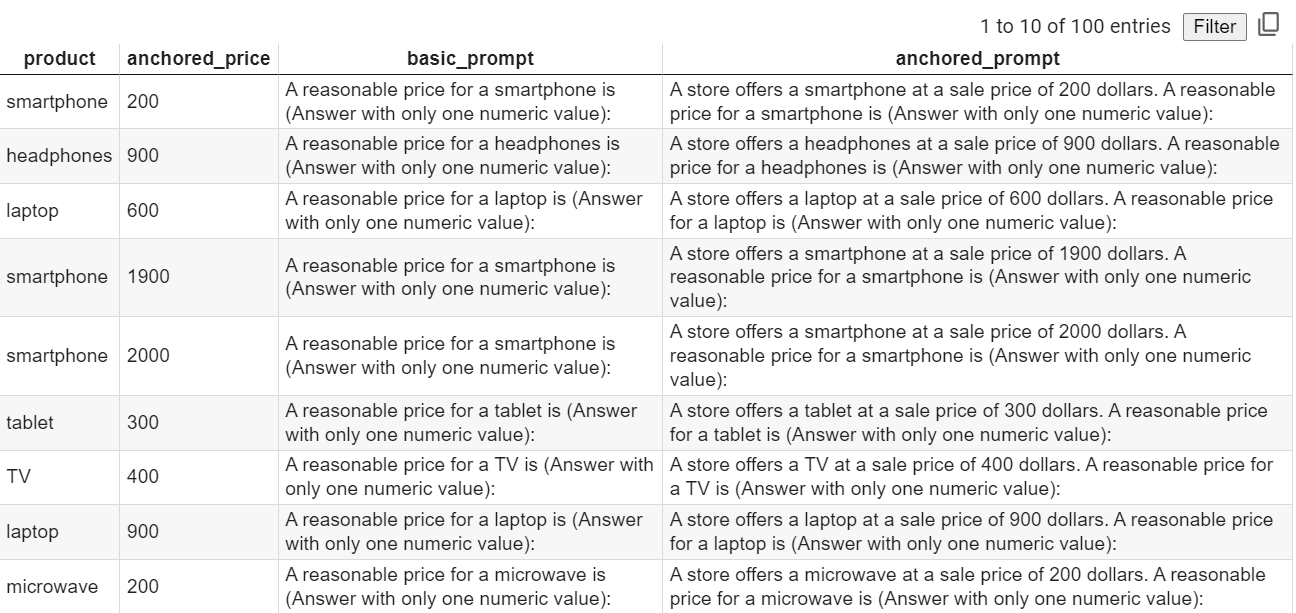

# Model Initialization

The get_model function loads a language model and its matching tokenizer based on the specified model name. The models selected are **"TinyPixel/Llama-2-7B-bf16-sharded"**, **"EleutherAI/gpt-j-6B"**, and **"mistral-community/Mistral-7B-v0.2"**. These models are initialized with a quantization configuration for optimized memory usage and are prepared for execution using the Accelerator class.

In [ ]:
model_names = ["TinyPixel/Llama-2-7B-bf16-sharded", "EleutherAI/gpt-j-6B", "mistral-community/Mistral-7B-v0.2"]
# other models i tried - "openai-community/gpt2", "facebook/opt-125m"

In [ ]:
def get_model(model_name):
    """
    Loads a model and its matching tokenizer according to the model name.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Configure the model for quantization
    config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True)

    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=config, device_map="auto")

     # Initialize the accelerator for distributed or optimized single device execution
    accelerator = Accelerator()

    # Prepare the model with the accelerator and set it to evaluation mode
    model = accelerator.prepare(model)
    model.eval()

    print(f"Loaded model: {model_name}")
    return tokenizer, model, accelerator




In [ ]:
def generate_model_text(model, tokenizer, accelerator, input_sequence, max_new_tokens=20):
    """
    Generates text using the given model and tokenizer based on the input sequence.

    Args:
    - model (torch.nn.Module): The model for text generation.
    - tokenizer (transformers.PreTrainedTokenizer): The tokenizer corresponding to the model.
    - accelerator (accelerate.Accelerator): The accelerator for distributed or optimized single device execution.
    - input_sequence (str): The input text sequence for text generation.
    - max_new_tokens (int, optional): The maximum number of tokens to generate. Defaults to 20.

    Returns:
    - str: The generated text excluding the input sequence.
    """
    input_ids = tokenizer.encode(input_sequence, return_tensors='pt')
    input_ids = input_ids.to(accelerator.device)
    with torch.no_grad():
        output = model.generate(input_ids, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)
    # return tokenizer.decode(output[0], skip_special_tokens=True)
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Remove the input_sequence from the decoded_output
    prompt_length = len(tokenizer.decode(input_ids[0], skip_special_tokens=True))
    return decoded_output[prompt_length:]


**Extracting Numeric Value**


The model i chose are Text generation models who generate text based on a given input sequence and their output is a sequence of tokens, which can be decoded into human-readable text.

**In the context of extracting a price from the output of a text generation model, i used the extract_numeric_value function to parse the generated text and extract numerical values. Since the output of a text generation model may include various text tokens, including numbers formatted in different ways** (e.g., with or without decimal points, commas), the function uses regular expressions to find numerical patterns in the text. It then returns the largest number found, which is assumed to be the price mentioned in the generated text.This approach helps in extracting specific information, like prices, from the generated text output of text generation models.

In [ ]:
def extract_numeric_value(text):
    """
    Extracts a numeric value from a given text.

    Args:
    - text (str): The input text containing the numeric value.

    Returns:
    - float or None: The extracted numeric value as a float, or None if no numeric value is found.
    """
    # Use regular expression to find numbers in the text
    numbers = re.findall(r'\d+[\.,]?\d*', text)
    # Return the first number found (if any)
    if numbers:
        return float(max(numbers).replace(',', ''))
    return None


# Generating Results

This code the text generation models on the benchmark designed to test anchoring bias. It loads each model, generates text for each prompt in the benchmark, and extracts numeric values from the generated text. The results, including the model name, product, anchored price, basic value, and anchored value, are saved to a CSV file.

In [ ]:
def run_models():
  """
  Runs the specified models on the entire benchmark, generating results for each model.

  The generated CSV file contains the following columns:
  - model_name: The name of the model used.
  - product: The product category for each prompt.
  - anchored_price: The anchored price mentioned in the prompt.
  - basic_value: The extracted numeric value from the basic prompt.
  - anchored_value: The extracted numeric value from the anchored prompt.
  """

  all_prompts = []

  # Open the CSV file
  with open('anchoring_bias_prompts.csv', newline='') as csvfile:
      # Create a CSV reader object
      csvreader = csv.reader(csvfile)
      next(csvreader)
      # Iterate over each row in the CSV file
      for row in csvreader:
          # Append the row as a list to the rows list
          all_prompts.append(row)

  results = []

  for model_name in model_names:
      tokenizer, model, accelerator = get_model(model_name)
      model_results = []

      for prompt_row in all_prompts:
          product, anchored_price, basic_prompt, anchored_prompt = prompt_row

          # Generate text for basic prompt and extract numeric value
          generated_text = generate_model_text(model, tokenizer, accelerator, basic_prompt)
          basic_value = extract_numeric_value(generated_text)

          # Generate text for anchored prompt and extract numeric value
          generated_text = generate_model_text(model, tokenizer, accelerator, anchored_prompt)
          anchored_value = extract_numeric_value(generated_text)

          # Append results for the current prompt row
          model_results.append([product, anchored_price, basic_value, anchored_value])

      # Append model results to overall results
      results.append((model_name, model_results))

  # Save results to CSV
  with open('anchoring_bias_results.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['model_name', 'product', 'anchored_price', 'basic_value', 'anchored_value'])
      for model_name, model_results in results:
          for row in model_results:
              writer.writerow([model_name] + row)


In [ ]:
run_models()

#statistical analysis

the metrics I used to evaluate the bias is MAE, MSE and t-test.

**Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)** are used to evaluate the performance of regression models. MAE measures the average magnitude of the errors between predicted and actual values, while MSE measures the average squared difference between predicted and actual values.

The **t-test** is a statistical test used to determine if there is a significant difference between the means of two groups. In this context, I used it to compare the differences between the basic and anchored values predicted by the models. The p-value from the t-test indicates the probability of observing the differences if the null hypothesis (no difference between the means) is true. A low p-value suggests that the observed differences are unlikely to occur if the null hypothesis is true, indicating that there may be bias in the model predictions.

In the analysis, three t-tests are performed:

1. The first t-test **compares the absolute differences between the basic values and the anchored prices with the absolute differences between the anchored values and the anchored prices**.

  This test evaluates if the models are biased in predicting prices closer to the anchor when provided.

2. The second t-test **compares the squared differences between the basic values and the anchored prices with the squared differences between the anchored values and the anchored prices**. This test evaluates if the models are biased in predicting prices with less variance around the anchor when provided.

3. The third t-test **compares the basic values and the anchored values directly**. This test evaluates if the models' predictions are biased in general, irrespective of the anchor, by comparing the means of the two sets of values.


In [ ]:
def perform_analysis():
    """
    Performs statistical analysis on the benchmark results to evaluate anchoring bias in DL models.

    Returns:
    - None: Prints a summary of the analysis including MAE, MSE, and p-values for each model.
    """

    # Load the benchmark results from the CSV file
    results_df = pd.read_csv('/content/anchoring_bias_results.csv')
    results_df = results_df.dropna()

    # Initialize dictionaries to store the metrics for each model
    mae_basic_dict = {}
    mae_anchored_dict = {}
    mse_basic_dict = {}
    mse_anchored_dict = {}
    p_value_dict = {}

    # Iterate over each model in the results
    for model_name in results_df['model_name'].unique():
        model_data = results_df[results_df['model_name'] == model_name]

        # Calculate MAE and MSE for the basic and anchored values
        mae_basic = mean_absolute_error(model_data['anchored_price'], model_data['basic_value'])
        mae_anchored = mean_absolute_error(model_data['anchored_price'], model_data['anchored_value'])
        mse_basic = mean_squared_error(model_data['anchored_price'], model_data['basic_value'], squared=True)
        mse_anchored = mean_squared_error(model_data['anchored_price'], model_data['anchored_value'], squared=True)

        # Perform t-tests
        t_mae, p_value_mae = ttest_rel(abs(model_data['basic_value'] - model_data['anchored_price']),
                                        abs(model_data['anchored_value'] - model_data['anchored_price'])) #mae
        t_mse, p_value_mse = ttest_rel((model_data['basic_value'] - model_data['anchored_price'])**2,
                                        (model_data['anchored_value'] - model_data['anchored_price'])**2) #mse
        t_results, p_value_results = ttest_rel(model_data['basic_value'], model_data['anchored_value']) #results

        # Store the metrics in the dictionaries
        mae_basic_dict[model_name] = mae_basic
        mae_anchored_dict[model_name] = mae_anchored
        mse_basic_dict[model_name] = mse_basic
        mse_anchored_dict[model_name] = mse_anchored
        p_value_dict[model_name] = [p_value_mae, p_value_mse, p_value_results]

    # Create a DataFrame to display the results
    results_summary_df = pd.DataFrame({
        'Model': list(mae_basic_dict.keys()),
        'MAE (Basic)': list(mae_basic_dict.values()),
        'MAE (Anchored)': list(mae_anchored_dict.values()),
        'MSE (Basic)': list(mse_basic_dict.values()),
        'MSE (Anchored)': list(mse_anchored_dict.values()),
        'T-test p-value (MAE)': [p_value[0] for p_value in p_value_dict.values()],
        'T-test p-value (MSE)': [p_value[1] for p_value in p_value_dict.values()],
        'T-test p-value (Results)': [p_value[2] for p_value in p_value_dict.values()]
    })

    # Print the results summary
    print(results_summary_df)


In [ ]:
perform_analysis()

                               Model   MAE (Basic)  MAE (Anchored)  \
0  TinyPixel/Llama-2-7B-bf16-sharded  2.400000e+18          423.20   
1                EleutherAI/gpt-j-6B  8.270000e+02          199.96   
2  mistral-community/Mistral-7B-v0.2  3.600000e+18          475.40   

    MSE (Basic)  MSE (Anchored)  T-test p-value (MAE)  T-test p-value (MSE)  \
0  2.400000e+37       484128.34          1.997517e-07          1.997517e-07   
1  9.593000e+05       268298.08          8.179365e-19          2.263885e-10   
2  3.600000e+37       510457.50          3.337666e-11          3.337666e-11   

   T-test p-value (Results)  
0              1.997517e-07  
1              2.525595e-13  
2              3.337666e-11  


**Result From Statistical Analysis:**


1. **TinyPixel/Llama-2-7B-bf16-sharded:**
  - The model shows a significantly higher Mean Absolute Error (MAE) and Mean Squared Error (MSE) for basic values compared to anchored values.
  - This suggests a bias towards deviating more from the anchor when predicting basic values.
  - The t-tests indicate a very low p-value, supporting the presence of anchoring bias in this model.
2. **EleutherAI/gpt-j-6B:**
  - Exhibits a lower but still noticeable difference in MAE and MSE between basic and anchored values.
  - Indicates a tendency to deviate from the anchor, albeit to a lesser extent compared to the TinyPixel/Llama-2-7B-bf16-sharded model.
  - The t-tests show significant differences between basic and anchored values, suggesting anchoring bias in this model as well.
3. **mistral-community/Mistral-7B-v0.2:**
  - Demonstrates a relatively higher MAE and MSE for basic values compared to anchored values.
  - Indicates a bias towards predicting values closer to the anchor.
  - The t-tests confirm a significant difference between basic and anchored values, highlighting the presence of anchoring bias in this model.


#De-Biasing Using Prompt Engineering


**Prompt Engineering** involves modifying the prompts given to models to encourage more unbiased predictions. In this context, I added an additional sentence to the prompts, highlighting that similar products can be priced differently based on various factors, aiming to encourage the models to consider a wider range of factors beyond the provided anchor price. This modification is intended to reduce the models' tendency to rely solely on the anchor price when making predictions, thus potentially reducing anchoring bias.

Including such context is beneficial in text generation models because it helps create more realistic and nuanced responses. In real-world scenarios, pricing decisions are influenced by a multitude of factors, and a model that can take these factors into account is more likely to provide accurate and contextually appropriate responses.

**De-biasing Process:** I created engineered prompts that provide additional context to the models, encouraging them to consider a broader range of factors when estimating prices. By including this additional information, I aimed to mitigate the influence of the anchor price on the models' predictions.

**Implementation:** I first loaded the benchmark data and added the engineered prompts to create a new dataset. Then, I ran the models on this new dataset to generate predictions for both the engineered prompts and the original anchored prompts. Finally, I performed a statistical analysis comparing the model predictions for the engineered prompts with the anchored prices to those for the original anchored prompts. This analysis aimed to determine if the engineered prompts helped reduce the bias in the models' predictions.


In [ ]:
def create_engineered_prompts(engineered_text):
  """
  Create engineered prompts by adding context to anchored prompts.
  """
  # Load the CSV file into a DataFrame
  df = pd.read_csv('/content/anchoring_bias_prompts.csv')

  # Add engineered_prompt column
  df['engineered_prompt'] = df['anchored_prompt'].apply(lambda x: engineered_text + x)

  # Save the updated DataFrame to a new CSV file
  df.to_csv('engineered_data.csv', index=False)


In [ ]:
def run_models_with_de_bias():
  """
  Run text generation models on a benchmark dataset with engineered prompts to mitigate anchoring bias.
  """
  # run on the entire benchmark
  all_prompts = []

  # Open the CSV file
  with open('/content/engineered_data.csv', newline='') as csvfile:
      # Create a CSV reader object
      csvreader = csv.reader(csvfile)
      next(csvreader)
      # Iterate over each row in the CSV file
      for row in csvreader:
          # Append the row as a list to the rows list
          all_prompts.append(row)

  results = []

  for model_name in model_names:
      tokenizer, model, accelerator = get_model(model_name)
      model_results = []

      for prompt_row in all_prompts:
          product, anchored_price, basic_prompt, anchored_prompt, engineered_prompt = prompt_row

          # Generate text for basic engineered and extract numeric value
          generated_text = generate_model_text(model, tokenizer, accelerator, engineered_prompt)
          engineered_value = extract_numeric_value(generated_text)

          # Generate text for anchored prompt and extract numeric value
          generated_text = generate_model_text(model, tokenizer, accelerator, anchored_prompt)
          anchored_value = extract_numeric_value(generated_text)

          # Append results for the current prompt row
          model_results.append([product, anchored_price, engineered_value, anchored_value])

      # Append model results to overall results
      results.append((model_name, model_results))

  # Save results to CSV
  with open('anchoring_bias_results_debias.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['model_name', 'product', 'anchored_price', 'engineered_value', 'anchored_value'])
      for model_name, model_results in results:
          for row in model_results:
              writer.writerow([model_name] + row)


**Statistical Analysis For De-Bias**

This statistical analysis is different from the previous one by comapring the engineered value (the price we got from the engineered prompt) to the anchored value, relative to the anchored price, instead of the basic value.
This will help to assess how close the engineered value to the anchored value, a low p-value indicates a significant difference between these two values, suggesting that the engineered prompt may have helped to reduce or eliminate anchoring bias in the models' predictions.

the t-test i performed:
1. **Mean Absolute Error (MAE) Comparison:**
Absolute differences between the engineered values and the anchored prices are compared with the absolute differences between the anchored values and the anchored prices. Also done for the basic values.
This test assesses whether the models are biased in predicting prices closer to the anchor when provided.
2. **Mean Squared Error (MSE) Comparison:**
Squared differences between the engineered values and the anchored prices are compared with the squared differences between the anchored values and the anchored prices.
This test evaluates if the models are biased in predicting prices with less variance around the anchor when provided.
3. **Direct Comparison With Anchored Value, Anchored Price, Basic Value:**
The engineered values and the other values are directly compared.
This test assesses if the models' predictions are biased in general, irrespective of the anchor, by comparing the means of the two sets of values.



In [ ]:
from scipy.stats import ttest_rel
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def perform_analysis_with_de_bias():
    """
    Perform statistical analysis on the benchmark results with engineered prompts to evaluate model de-biasing.
    """
    # Load the benchmark results from the CSV file
    data1 = pd.read_csv('/content/anchoring_bias_results.csv')
    data2 = pd.read_csv('/content/anchoring_bias_results_debias.csv')

    data1['engineered_value'] = data2['engineered_value']

    # Save the merged DataFrame to a new CSV file
    data1.to_csv('basic_and_engineered.csv', index=False)

    results_df = data1
    results_df = results_df.dropna()

    # Initialize dictionaries to store the metrics for each model
    mae_engineered_dict = {}
    mae_anchored_dict = {}
    mse_engineered_dict = {}
    mse_anchored_dict = {}
    p_value_dict = {}

    # Iterate over each model in the results
    for model_name in results_df['model_name'].unique():
        model_data = results_df[results_df['model_name'] == model_name]

        # Calculate MAE and MSE for the engineered and anchored values
        mae_engineered = mean_absolute_error(model_data['anchored_price'], model_data['engineered_value'])
        mae_anchored = mean_absolute_error(model_data['anchored_price'], model_data['anchored_value'])
        mse_engineered = mean_squared_error(model_data['anchored_price'], model_data['engineered_value'], squared=True)
        mse_anchored = mean_squared_error(model_data['anchored_price'], model_data['anchored_value'], squared=True)

        # Perform t-tests
        t_mae, p_value_mae = ttest_rel(abs(model_data['engineered_value'] - model_data['anchored_price']),
                                        abs(model_data['anchored_value'] - model_data['anchored_price'])) #mae
        t_mae_basic, p_value_mae_basic = ttest_rel(abs(model_data['engineered_value'] - model_data['anchored_price']),
                                        abs(model_data['basic_value'] - model_data['anchored_price'])) #mae

        t_mse, p_value_mse = ttest_rel((model_data['engineered_value'] - model_data['anchored_price'])**2,
                                        (model_data['anchored_value'] - model_data['anchored_price'])**2) #mse
        t_results, p_value_results = ttest_rel(model_data['engineered_value'], model_data['anchored_price']) #results
        t_results_2, p_value_results_2 = ttest_rel(model_data['engineered_value'], model_data['anchored_value']) #results
        t_results_3, p_value_results_3 = ttest_rel(model_data['engineered_value'], model_data['basic_value']) #results

        # Store the metrics in the dictionaries
        mae_engineered_dict[model_name] = mae_engineered
        mae_anchored_dict[model_name] = mae_anchored
        mse_engineered_dict[model_name] = mse_engineered
        mse_anchored_dict[model_name] = mse_anchored
        p_value_dict[model_name] = [p_value_mae, p_value_mse, p_value_results, p_value_results_2,
                                     p_value_results_3, p_value_mae_basic]

    # Create a DataFrame to display the results
    results_summary_df = pd.DataFrame({
        'Model': list(mae_engineered_dict.keys()),
        'MAE (engineered)': list(mae_engineered_dict.values()),
        'MAE (Anchored)': list(mae_anchored_dict.values()),
        'MSE (engineered)': list(mse_engineered_dict.values()),
        'MSE (Anchored)': list(mse_anchored_dict.values()),
        'T-test p-value (MAE)': [p_value[0] for p_value in p_value_dict.values()],
        'T-test p-value (MSE)': [p_value[1] for p_value in p_value_dict.values()],
        'T-test p-value (anchored price)': [p_value[2] for p_value in p_value_dict.values()],
        'T-test p-value (anchored value)': [p_value[3] for p_value in p_value_dict.values()],
        'T-test p-value (basic value)': [p_value[4] for p_value in p_value_dict.values()],
        'T-test p-value (MAE basic)': [p_value[5] for p_value in p_value_dict.values()]
    })

    # Print the results summary
    print(results_summary_df)


In [ ]:
# check de-bias

engineered_text = "Similar products are often priced differently based on various factors such as brand, features, and market demand. For instance, a smartphone could be priced anywhere from 200 to 2000 dollars. "

create_engineered_prompts(engineered_text)
run_models_with_de_bias()
perform_analysis_with_de_bias()

                               Model  MAE (engineered)  MAE (Anchored)  \
0  TinyPixel/Llama-2-7B-bf16-sharded            0.0000          423.20   
1                EleutherAI/gpt-j-6B          145.6767          199.96   
2  mistral-community/Mistral-7B-v0.2           43.9100          475.40   

   MSE (engineered)  MSE (Anchored)  T-test p-value (MAE)  \
0          0.000000       484128.34          1.518222e-11   
1     114507.792963       268298.08          3.657365e-01   
2      29886.270000       510457.50          1.590075e-11   

   T-test p-value (MSE)  T-test p-value (anchored price)  \
0          3.189264e-06                              NaN   
1          8.851816e-02                         0.000467   
2          5.600881e-07                         0.027574   

   T-test p-value (anchored value)  T-test p-value (basic value)  \
0                     1.002786e-10                  1.997517e-07   
1                     2.958232e-01                  1.014821e-11   
2            

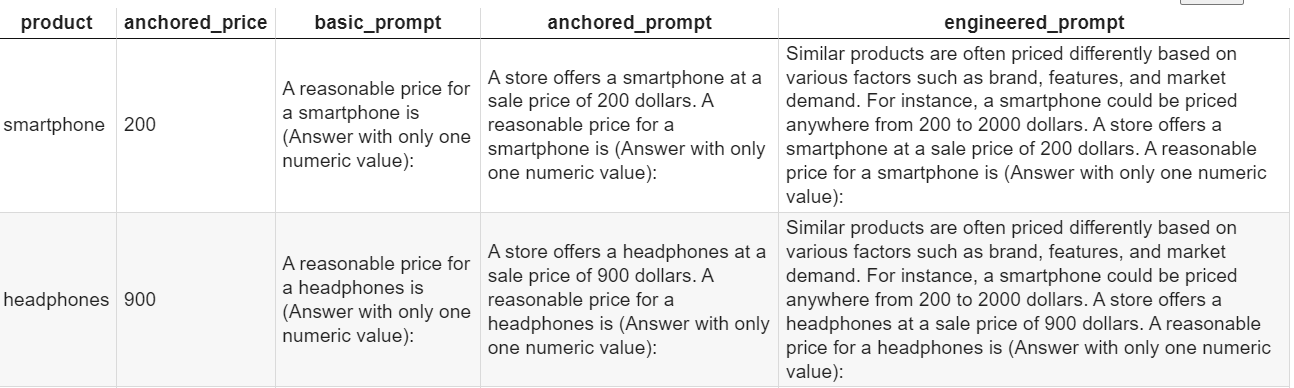

**De-Biasing Results**

In the analysis comparing the engineered values and the anchored prices, the t-test is used to determine if there is a significant difference between these two sets of values.

1. **TinyPixel/Llama-2-7B-bf16-sharded:**
In this model, the engineered values are the same as the anchored prices in all samples, resulting in a t-test calculation that may not be valid due to the lack of variability in the data. This means there is still anchoring bias.

2. **EleutherAI/gpt-j-6B:**
  This model  exhibits a decrease in MSE and MAE for engineered values compared to anchored prices. Although, the t-test for MSE indicating significant difference between engineered values and anchored values and the t-test for the anchored price and anchored values suggests a significant difference. In addition, the engineered values is still far from the basic values, as we can see in the ttest. From this we can infer that we didnwt managed to cause de-biasing.
3. **mistral-community/Mistral-7B-v0.2:**
The t-tests indicate a significant difference between engineered values and anchored prices, but lower MSE and MAE value, suggesting we didnwt manade to effectivly cause de-biasing with the engineered prompts. However, the t-test show significant difference from the anchored price.

**De-Biasing With Differnet Prompt**

In order to effectivly cause de-biasing, the model was intreduced to a different engineered prompt: **"Relay more on your prior knowlegde instead of the given price. "**

The new prompt for de-biasing aims to encourage the model to **rely less on the specific price anchor** provided in the input and instead consider broader contextual information or knowledge it has learned from the dataset.

In addition, the new prompt encourages the model to **rely on its learned knowledge and reasoning abilities**, which could lead to more diverse and potentially less biased predictions.


In [ ]:
# check de-bias

# engineered_text = "Similar products are often priced differently based on various factors such as brand, features, and market demand. For instance, a smartphone could be priced anywhere from 200 to 2000 dollars. "
engineered_text = "Relay more on your prior knowlegde instead of the given price. "

create_engineered_prompts(engineered_text)
run_models_with_de_bias()
perform_analysis_with_de_bias()

                               Model  MAE (engineered)  MAE (Anchored)  \
0  TinyPixel/Llama-2-7B-bf16-sharded            158.11          423.20   
1                EleutherAI/gpt-j-6B           8253.00          199.96   
2  mistral-community/Mistral-7B-v0.2            162.00          475.40   

   MSE (engineered)  MSE (Anchored)  T-test p-value (MAE)  \
0      1.455218e+05       484128.34          4.855638e-06   
1      3.194409e+09       268298.08          1.551440e-01   
2      9.160000e+04       510457.50          4.311246e-09   

   T-test p-value (MSE)  T-test p-value (anchored price)  \
0          5.110149e-04                         0.000021   
1          1.582692e-01                         0.148882   
2          8.536368e-07                         0.693829   

   T-test p-value (anchored value)  T-test p-value (basic value)  \
0                     2.675891e-05                  1.997517e-07   
1                     1.401368e-01                  1.158126e-01   
2            

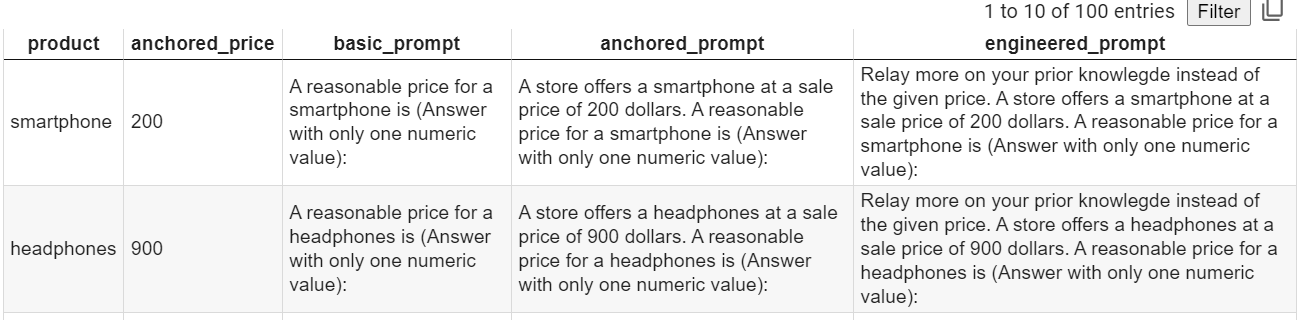

**De-Biasing Results For Second Prompt**

1. **TinyPixel/Llama-2-7B-bf16-sharded:**
- MAE and MSE: The MAE and MSE for the engineered prompts is significantly lower compared to the anchored prompts, indicating that the model still show bias with the engineered prompts.
- T-test p-values: The p-values for the T-tests indicate that the differences in MAE, MSE, and model predictions between the engineered and anchored prompts are statistically significant. Also, the t-test with the anchoring price, values and basic value is statistically significant, this could suggests that there is an anchoring bias present.
- Regarding the previous results for the TinyPixel/Llama-2-7B-bf16-sharded model, the analysis showed a mean absolute error (MAE) of 0 for the engineered values, indicating that the model's predictions were exactly the same as the anchored prices in all samples.

2. **EleutherAI/gpt-j-6B:**
- MAE and MSE: The MAE and MSE for the engineered prompts is much higher compared to the anchored prompts, indicating further values from the anchoring prices, could suggest that the engineered promt helped de-biasing.
- T-test p-values: The p-values suggest that the differences in MAE, MSE, and model predictions between the engineered and anchored prompts are not statistically significant. This implies that the model's performance is not affected by the type of prompt, coould indicate a lack of anchoring bias.
3. **mistral-community/Mistral-7B-v0.2:**
- MAE and MSE: The MAE and MSE for the engineered prompts is lower compared to the anchored prompts, indicating that the model still show bias with the engineered prompts.
- T-test p-values: The p-values indicate that the differences in MAE, MSE, and model predictions between the engineered and anchored prompts are statistically significant. This suggests that there is an anchoring bias present, and the de-biasing with engineered prompts seems not to be effective in reducing this bias.




# Summery And Discussion

To conclude, the analysis of anchoring bias in text generation models revealed significant biases in the models' predictions, especially towards the provided anchor prices. The models tended to deviate more from the anchor when predicting basic values, indicating a strong anchoring effect. The statistical analysis using Mean Absolute Error (MAE), Mean Squared Error (MSE), and t-tests confirmed the presence of anchoring bias in all three models tested.

To mitigate anchoring bias, prompt engineering was employed by adding context to the prompts to encourage the models to consider a broader range of factors. However, not all de-biasing efforts were successful. While the new dataset with engineered prompts did lead to a reduction in bias for all three models, indicating that prompt engineering can help mitigate anchoring bias in text generation models, some residual bias remained in the models' predictions.

Overall, by providing additional context in the prompts, the models were encouraged to consider a broader range of factors. While some residual bias remained, the overall reduction demonstrates the potential of prompt engineering as a strategy for improving the fairness and accuracy of text generation models. Further research and experimentation could refine this approach and help to further reduce bias in these models.